In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy.stats import norm, zscore
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import umap
import warnings
from scipy.cluster import hierarchy

warnings.filterwarnings('ignore')

sys.path.append('../funcs')

import proteomics as prot
import processing as pp
import plotting as pl
from utils import get_pcs, remove_covariates, plot_pca, plot_pca_gridplot, plot_pca_ax
import nmf_utilities as nmu
import signatureanalyzer as sa

In [3]:
DATA_DIR = "../data/processed/061721"
NMF_FILE = "signatures/061721_imputed_res_reg/nmf_output.h5"
PLOTS_DIR = "figures/ardnmf/061721_imputed_res_reg"
MAPPING_FILE = "gs://cptac-pancan-getzlab/mapping/PanCan_Participant_freeze_mapping.tsv"
MUT_SIG = "gs://cptac-pancan-getzlab/Freeze_061721/mutational_signatures/Full_H_compressed_v1.1.tsv"
DENDRO_GROUPS = "gs://cptac-pancan-getzlab/Freeze_061721/dendrogram/dendro_map_061721.tsv"
H_CORR = "gs://cptac-pancan-getzlab/Freeze_061721/dendrogram/cosine_sim_H.tsv"
RUN_NAME = NMF_FILE.split("/")[-2]

DIFF = 0.1
MAX_NORM = 0.25

os.makedirs(PLOTS_DIR, exist_ok=True)

## 1. Load Mutational Signatures
---

In [4]:
H_mut = pd.read_csv(MUT_SIG, sep='\t', index_col=0)
mut2Prot_dict = pd.read_csv(MAPPING_FILE,sep='\t', index_col=0).set_index('WXS').to_dict()['Proteome_Sample_ID']
H_mut.index = H_mut.index.map(mut2Prot_dict)
H_mut = H_mut.drop('X03BR011')

# Thresholds
H_mut_apobec = H_mut.apply(lambda x: x['APOBEC'] if ((x.div(x.sum())['APOBEC']>=0.2) and (x['APOBEC']>20)) else 0, 1)
H_mut_hrd = H_mut.apply(lambda x: x['HRD'] if x['HRD']>=45 else 0, 1)
H_mut_smoking = H_mut.apply(lambda x: x['Tobacco Smoking'] if ((x.div(x.sum())['Tobacco Smoking']>=0.1) and (x['Tobacco Smoking']>10)) else 0, 1)

H_mut['HRD'] = H_mut_hrd
H_mut['APOBEC'] = H_mut_apobec
H_mut['Tobacco Smoking'] = H_mut_smoking
H_mut['TMB'] = H_mut.sum(1)

HRD_patients = H_mut.index[H_mut['HRD']>0].to_list()

pastel_col = sns.color_palette('pastel',10)
bright_col = sns.color_palette('bright',10)

mut_colors = {
    'POLE':"#5DDCF2",
    'POLE+MSI':"#1E88E5",
    'CpG>T + Short Indels':"#9250FE",
    'APOBEC':"#004D40",
    'CpG>T': "#DCBEB3",
    'MMRD':"#FFC107", 
    'Unknown (SBS8 0.64)':"#41B261",
    'Tobacco Smoking':"#450F6F",
    'UV Exposure': "#FE98AB",
    'HRD': "#D81B60",
    'NHR1: Unknown(SBS40 0.94)': "#CBE07E"
}

# Include ESTIMATE Score for plotting
resd = prot.loadImmuneDeconv("Fig_immuno_metabolism/ImmuneDeconv")
H_mut = H_mut.join(resd['estimate']['ESTIMATEScore'])


## 2. DendroGram
---

In [5]:
corr_raw_mat = pd.read_csv(H_CORR, sep='\t', index_col=0)
C = prot.ss_linkage_cut(corr_raw_mat)
groups_df = prot.ss_linkage_groups(C, lim=39)

samples_df = pd.read_csv(MAPPING_FILE, sep='\t', index_col=0)
meta = samples_df.set_index('Proteome_Sample_ID')['cohort'].loc[corr_raw_mat.columns]
meta.name = 'cohort'

  * 41 group comparisons


In [6]:
# Cluster information
#clust_df = pd.read_csv('signatures/061721_imputed_res_reg/mappings_pancan_102322.tsv', sep='\t',index_col=0)
clust_df = pd.read_csv('../analysis/signatures/061721_imputed_res_reg/Hierarchical_Clustering/cluster_map.tsv', sep='\t', index_col=0)
clust_df = clust_df.loc[corr_raw_mat.columns]

In [7]:
# Expression signatures
sigs_order = [
    'S20',
    'S13',
    'S8',
    'S5',
    'S29',
    'S1',
    'S27',
    'S11',
    'S7',
    'S12',
    'S19',
    'S23',
    'S18',
    'S24',
    'S28',
    'S6',
    'S17',
    'S21',
    'S16',
    'S4',
    'S3',
    'S2',
    'S15',
    'S25',
    'S30',
    'S9',
    'S22',
    'S14',
    'S26',
    'S32',
    'S10',
    'S33',
    'S31'
]

W = pd.read_hdf(NMF_FILE, "W")
DATA_DIR = "../data/processed/061721"
pmap_df = pd.read_csv(os.path.join(DATA_DIR, "var_map_full.tsv"),sep='\t',index_col=0)

# Count features
W = W[['max_id','max','max_norm']]
W['n'] = [-1 if x else 1 for x in W.index.str.endswith('_n')]
W['max'] = W['max']*W['n']
W['max_norm'] = W['max_norm']*W['n']
W.index = W.index.str.replace('_n','')
W = W.join(pmap_df[['geneSymbol','feature']])
W['feature'] = W['feature'].str.capitalize()

W_count_df = W.groupby(['max_id','feature']).size().reset_index().pivot(index='max_id',columns='feature',values=0)

# Load Hraw
Hraw = pd.read_hdf(NMF_FILE, "Hraw").T
Hraw = Hraw.loc[:,sigs_order]

In [9]:
rna_file = "../data/processed/061721/rna/tumor_rna_tpm_norm_combat_X.parquet"
protein_file = "../data/processed/061721_genecentric/imputed/proteome_X.tsv.gz"
phosphoprotein_file = "../data/processed/061721/imputed_res/phosphoproteome_X.parquet"

var_map_file = "../data/processed/061721/var_map_full.tsv"

In [10]:
# Cluster information
clust_df = pd.read_csv('../analysis/signatures/061721_imputed_res_reg/Hierarchical_Clustering/cluster_map.tsv', sep='\t', index_col=0)

# Raw data
rna_df = pd.read_parquet(rna_file).loc[:,clust_df.index]
phosph_df = pd.read_parquet(phosphoprotein_file).loc[:,clust_df.index]
prot_df = pd.read_csv(protein_file, sep='\t', index_col=0).loc[:,clust_df.index]

# Mapping file
map_df = pd.read_csv(var_map_file, sep='\t', index_col=0)

In [11]:
from typing import Union
from scipy.stats import zscore

def _feature_heatmap(
    mat_df: pd.DataFrame,
    ax = None,
    fig = None,
    cbar_ax = None,
    dax = None,
    metric: str = 'euclidean',
    method: str = 'ward',
    color_thresh_scale: float = 0,
    figsize: tuple = (8,6),
    p: int = 30,
    vmax: Union[float, None] = None,
    vmin: Union[float, None] = None,
    cmap: str = 'coolwarm'
    ):
    """
    Feature heatmap with Dendrogram.
    """
    from scipy.cluster import hierarchy
    import scipy.cluster.hierarchy as shc
    from sklearn.cluster import AgglomerativeClustering
    import matplotlib as mpl
    from matplotlib.pyplot import cm

    # Create heatmap
    if ax is None and fig is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if vmax is None:
        cbar_top_lim = np.max(mat_df.values)
    else:
        cbar_top_lim = vmax

    if vmin is None:
        cbar_bottom_lim = 0
    else:
        cbar_bottom_lim = vmin
    
    # Compute feature order
    d_linkage = shc.linkage(mat_df, metric=metric, method=method)
    dres = shc.dendrogram(d_linkage, p=p, no_plot=True)
    dgram_idx = list(map(int, dres['ivl']))

    sns.heatmap(
        mat_df.iloc[dgram_idx,:].values,
        ax=ax,
        cbar_ax=cbar_ax,
        cbar_kws = {'ticks':[cbar_bottom_lim, cbar_top_lim]},
        rasterized=True,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap
    )

    ax.set_xticks([])
    ax.set_yticks([])

    x0 = ax.get_position().x0
    x1 = ax.get_position().x1
    y0 = ax.get_position().y0
    y1 = ax.get_position().y1

    buf = y1*0.015
    
    if dax is None:
        dax = fig.add_axes([x0-0.15-buf, y0, 0.15, y1*0.86])

    cmap = cm.rainbow(np.linspace(0, 1, 10))
    hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

    dres = shc.dendrogram(
        d_linkage,
        p=p,
        ax=dax,
        above_threshold_color="grey",
        color_threshold=color_thresh_scale*max(d_linkage[:,2]),
        orientation='left'
    )

    dax.set_xticks([])
    dax.set_yticks([])
    [dax.spines[x].set_visible(False) for x in ['top','right','bottom','left']]
    
def grab_msigdb_genes(gmt, term):
    """Grab genes corresponding to term."""
    
    with open(gmt) as f:
        annots = {}
        for line in f:
            line_s = line.strip().split('\t')
            annots[line_s[0]] = line_s[2:]
    
    if isinstance(term, list):
        genes = list()
        for t in term:
            genes += annots[t]
        
        return list(set(genes))
    else:
        return annots[term]

def filt_feats_matrix(
    mat_df, 
    map_df, 
    pw="HALLMARK_DNA_REPAIR", 
    gmt="../data/ref/gmts/h.all.v7.0.symbols.gmt.txt"):
    """
    Grab features from matrix.
    
    """
    # Get genes
    gene_list = grab_msigdb_genes(gmt, pw)
    
    # Filter
    feature_indices = np.intersect1d(map_df[map_df['geneSymbol'].isin(gene_list)].index, mat_df.index)
    
    if feature_indices.shape[0]==0:
        feature_indices = np.intersect1d(gene_list, mat_df.index)
    
    return mat_df.loc[feature_indices,:]

## 3. Load Expression Differential Expression Data
---

In [12]:
PROLIF_SET = [
    "HALLMARK_KRAS_SIGNALING_UP",
    "HALLMARK_MYOGENESIS",
    "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION",
    "HALLMARK_P53_PATHWAY",
    "HALLMARK_MITOTIC_SPINDLE",
    "HALLMARK_APICAL_JUNCTION"
]

DDR_SET = [
    "HALLMARK_DNA_REPAIR",
    "HALLMARK_E2F_TARGETS",
    "HALLMARK_MYC_TARGETS_V1",
    "HALLMARK_MYC_TARGETS_V2",
    "HALLMARK_UV_RESPONSE_UP",
    "HALLMARK_G2M_CHECKPOINT",
]

METAB_SET = [
    "HALLMARK_FATTY_ACID_METABOLISM",
    "HALLMARK_OXIDATIVE_PHOSPHORYLATION",
    "HALLMARK_GLYCOLYSIS"
]

In [17]:
de_df = pd.read_csv("diffexp/061721_raw_dendro/full_de_cohort_cov.tsv", sep="\t", index_col=0)

In [14]:
features_list = list(rna_df.index) + list(prot_df.index) + list(phosph_df.index)

In [15]:
def filter_de_mat_pw(
    de_df, 
    idx, 
    features_list, 
    pw=None, 
    positive=True, 
    fc_lim=0, 
    pval_lim=0.1, 
    gmt="../data/ref/gmts/h.all.v7.0.symbols.gmt.txt",
    ntop_rna=None,
    ntop_prot=None,
    ntop_phosph=None
    ):
    """Filter De Matrix by pathways."""
    
    if pw is not None:
        genes = grab_msigdb_genes(gmt, pw)
    else:
        genes = set(de_df['gene_name'])
    
    if positive:
        df = de_df[
            (de_df['id']==idx) & 
            (de_df['feature'].isin(['transcriptome','proteome','phosphoproteome'])) &
            (de_df['adj.P.Val'] <= pval_lim) &
            (de_df['logFC'] > fc_lim) &
            (de_df['gene_name'].isin(genes)) & 
            (de_df['index'].isin(features_list))
        ]
        
        if ntop_rna is None:
            ntop_rna = df[df['feature']=='transcriptome'].shape[0]
        if ntop_prot is None:
            ntop_prot = df[df['feature']=='proteome'].shape[0]
        if ntop_phosph is None:
            ntop_phosph = df[df['feature']=='phosphoproteome'].shape[0]
        
        return pd.concat([
            df[df['feature']=='transcriptome'].sort_values('gsea_rank', ascending=False).iloc[:ntop_rna,:],
            df[df['feature']=='proteome'].sort_values('gsea_rank', ascending=False).iloc[:ntop_prot,:],
            df[df['feature']=='phosphoproteome'].sort_values('gsea_rank', ascending=False).iloc[:ntop_phosph,:]
        ])
        
    else:
        df = de_df[
            (de_df['id']==idx) & 
            (de_df['feature'].isin(['transcriptome','proteome','phosphoproteome'])) &
            (de_df['adj.P.Val'] <= pval_lim) &
            (de_df['logFC'] < fc_lim) &
            (de_df['gene_name'].isin(genes)) &
            (de_df['index'].isin(features_list))
        ]
        
        if ntop_rna is None:
            ntop_rna = df[df['feature']=='transcriptome'].shape[0]
        if ntop_prot is None:
            ntop_prot = df[df['feature']=='proteome'].shape[0]
        if ntop_phosph is None:
            ntop_phosph = df[df['feature']=='phosphoproteome'].shape[0]
        
        return pd.concat([
            df[df['feature']=='transcriptome'].sort_values('gsea_rank').iloc[:ntop_rna,:],
            df[df['feature']=='proteome'].sort_values('gsea_rank').iloc[:ntop_prot,:],
            df[df['feature']=='phosphoproteome'].sort_values('gsea_rank').iloc[:ntop_phosph,:]
        ])

In [18]:
de1_df = filter_de_mat_pw(de_df, 1, features_list, pw=DDR_SET, 
                          positive=True, ntop_rna=75, ntop_prot=50, ntop_phosph=25)

de2_df = filter_de_mat_pw(de_df, 1, features_list, pw=PROLIF_SET, 
                          positive=False, ntop_rna=75, ntop_prot=50, ntop_phosph=25)

In [30]:
ddr = {x:set(grab_msigdb_genes("../data/ref/gmts/h.all.v7.0.symbols.gmt.txt",x)) for x in DDR_SET}
prolif = {x:set(grab_msigdb_genes("../data/ref/gmts/h.all.v7.0.symbols.gmt.txt",x)) for x in PROLIF_SET}

In [61]:
for idx,row in de1_df.iterrows():
    pathways_found = []
    
    for key in ddr.keys():
        if row['gene_name'] in ddr[key]:
            pathways_found.append(key)
            
    de1_df.loc[idx,'pathways_found'] = str(pathways_found)
    de1_df.loc[idx,'pathways_found_n'] = int(len(pathways_found))

In [67]:
for idx,row in de2_df.iterrows():
    pathways_found = []
    
    for key in prolif.keys():
        if row['gene_name'] in prolif[key]:
            pathways_found.append(key)
            
    de2_df.loc[idx,'pathways_found'] = str(pathways_found)
    de2_df.loc[idx,'pathways_found_n'] = int(len(pathways_found))

In [104]:
rna_sub_df = rna_df.loc[de1_df[de1_df['feature']=='transcriptome']['index']]
prot_sub_df = prot_df.loc[de1_df[de1_df['feature']=='proteome']['index']]
phosph_sub_df = phosph_df.loc[de1_df[de1_df['feature']=='phosphoproteome']['index']]

rna_sub2_df = rna_df.loc[de2_df[de2_df['feature']=='transcriptome']['index']]
prot_sub2_df = prot_df.loc[de2_df[de2_df['feature']=='proteome']['index']]
phosph_sub2_df = phosph_df.loc[de2_df[de2_df['feature']=='phosphoproteome']['index']]

In [72]:
# Color scheme
cluster_cmap = [item for sublist in [
    sns.color_palette("Greys", 2).as_hex()[::-1],
    sns.color_palette("Purples", 5).as_hex()[::-1],
    sns.color_palette("Blues", 9).as_hex()[::-1],
    sns.color_palette("Oranges", 10).as_hex()[::-1]
] for item in sublist]

cluster_cmap = {'C'+str(idx+1):x for idx,x in enumerate(cluster_cmap)}

## 4. Full Composite Figure
---

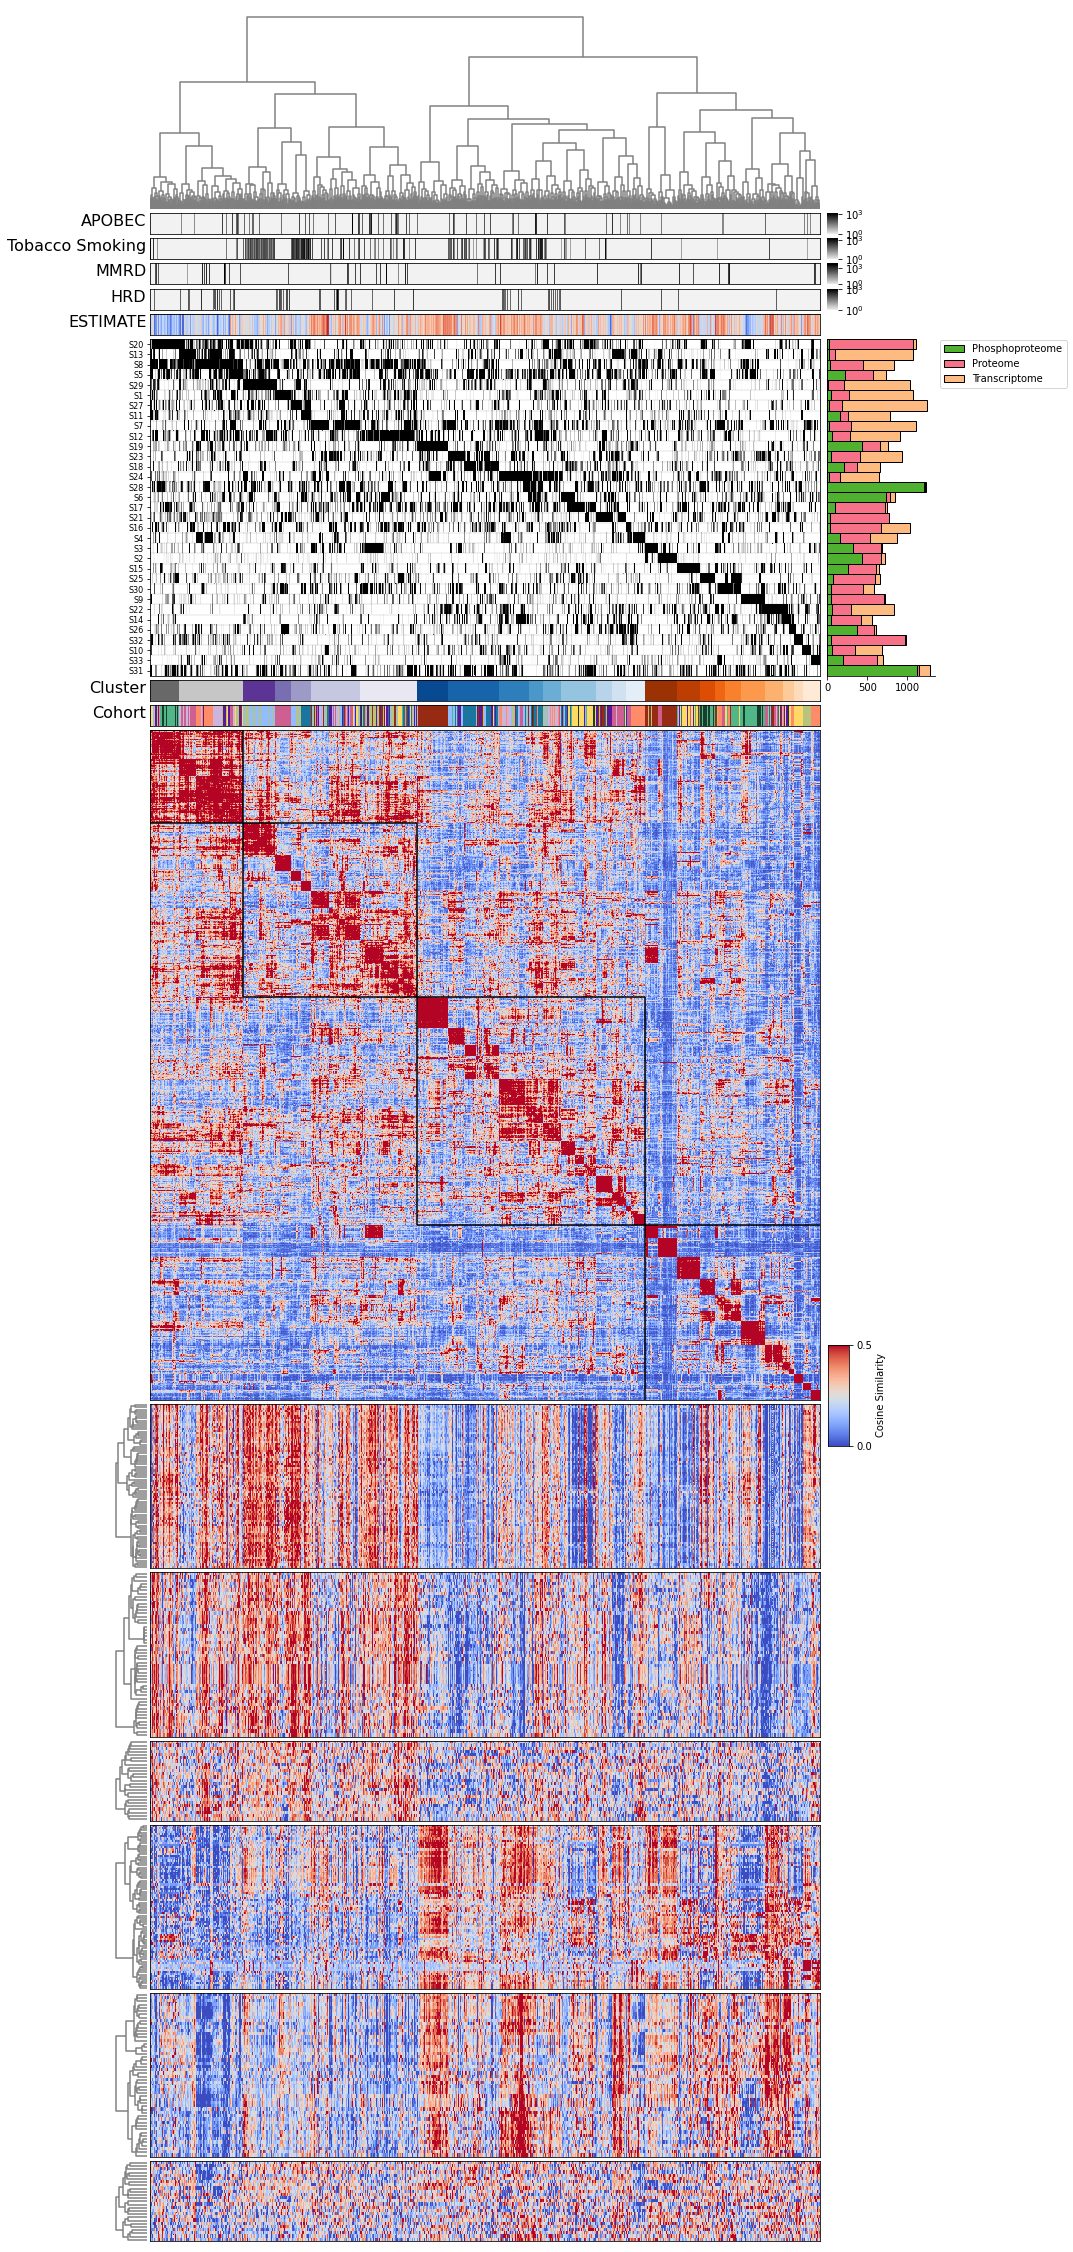

In [190]:
import importlib; importlib.reload(pl)

f,d,dres,d_linkage = pl.plot_cmatrix_fig2(
    corr_raw_mat,
    n_clusters=4,
    metas=[],
    vmax=0.5,
    cbar_label='Cosine Similarity',
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    plot_cluster_lines=True,
    dendro_meta=meta,
    dendro_flag=False,
    dendro_cmap=pl.CPTAC_CMAP,
    dendro_groups_df=groups_df,
    dendro_meta_clust=clust_df['cluster_id'],
    color_thresh_scale=0,
    figsize=(12,14),
    H_mut=H_mut,
    mut_colors=mut_colors,
    show_xlab=False,
    show_upper_triangle=False,
    H_sig=Hraw,
    W_prop=W,
    ax11_plot=filt_feats_matrix(rna_sub_df, map_df, pw=DDR_SET).T.apply(zscore).T,
    ax12_plot=filt_feats_matrix(prot_sub_df, map_df, pw=DDR_SET).T.apply(zscore).T,
    ax13_plot=filt_feats_matrix(phosph_sub_df, map_df, pw=DDR_SET).T.apply(zscore).T,
    ax21_plot=filt_feats_matrix(rna_sub2_df, map_df, pw=PROLIF_SET).T.apply(zscore).T,
    ax22_plot=filt_feats_matrix(prot_sub2_df, map_df, pw=PROLIF_SET).T.apply(zscore).T,
    ax23_plot=filt_feats_matrix(phosph_sub2_df, map_df, pw=PROLIF_SET).T.apply(zscore).T
)

plt.savefig(os.path.join(PLOTS_DIR, "fig2A_v3.pdf"), dpi=300, bbox_inches='tight')